![title](Twitter.png "Header")

<h1>Twitter Tweet's Model For Identifying Real Disaster Tweet's</h1>

**Data Source :-** https://www.kaggle.com/c/nlp-getting-started/data <br>

**Twitter Tweet's Data Overview :-**<br>

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).
But, it’s not always clear whether a person’s words are actually announcing a disaster or what.

So, to indentify this I have build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

***Number of Tweet's in Train Data-Set :-*** 7,613<br> 
***Number of Tweet's in Test Data-Set :-*** 3263<br>
***Total Number of Tweet's :-*** 10,876<br>

**Attribute's Information :-**<br>

***1.*** id - a unique identifier for each tweet<br>
***2.*** keyword - a particular keyword from the tweet (may be blank)<br>
***3.*** location - the location the tweet was sent from (may be blank)<br>
***4.*** text - the text of the tweet<br>
***5.*** target - this denotes whether a tweet is about a real disaster (1) or not (0)<br>


# 1. Importing Libraries :-

In [1]:
import numpy as np
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from matplotlib import rcParams
from wordcloud import WordCloud
from matplotlib import rc_params
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from prettytable import PrettyTable

In [2]:
%matplotlib inline
rcParams["figure.figsize"] = 8,8
sns.set_style("darkgrid")
# plt.style.use('ggplot')

# 2. Loading The Data-Set's :-

***There are three files to load :-***<br><br>
**2.1.** train.csv (consisting of {id, keyword, location, text, target} as columns)<br>
**2.2.** test.csv  (consisting of {id, keyword, location, text} as columns)<br>
**2.3.** y_test.csv  (consisting of target column of test.csv data)<br>

# 2.1. Loading Train Data :-

In [3]:
train = pd.read_csv("train.csv")
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


By loading **train.csv** we can see through **train.info()** & through **train.head()** that there are columns having **missing values(NaN).**

# 2.2. & 2.3. Loading Test Data with y_test Data :-

In [4]:
test = pd.read_csv("test.csv")
y_test = pd.read_csv("y_test.csv")

# Droping id column from y_test data-set as that same id is present in test data-set in same order.
y_test = y_test.drop("id", axis=1)

# Joining test with y_test data-set to make a complete new test data-set.
test = pd.DataFrame.join(test, y_test)
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
 4   target    3263 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 127.6+ KB
None


,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0


After creating a **New Test Data** we can see through **test.info()** & through **test.head()** that there are columns having **missing values(NaN)**.

In [5]:
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 5 columns in test


There are **7613 rows** and **5 columns** in **Train**<br>
There are **3263 rows** and **5 columns** in **Test**

# 3. Exploratory Data Analysis (EDA) :-<br>

***Following are the parts of Exploratory Data Analysis (EDA) :-***<br><br>
**3.1.** Heatmap For Finding Both Data-Frame's Missing Values<br>
**3.2.** Top 10 Locations From Both Data Tweet's<br>
**3.3.** Data Cleaning<br>
&nbsp;&nbsp;&nbsp;&nbsp;**3.3.1** Distribution Of Classes<br>
&nbsp;&nbsp;&nbsp;&nbsp;**3.3.2** Top 10 Keywords From Both Data Tweets<br>
**3.4.** Data Pre-Processing<br>
&nbsp;&nbsp;&nbsp;&nbsp;**3.4.1.** Creating Final Data-Frame (Inclusive Of Train & Test Both)<br>
&nbsp;&nbsp;&nbsp;&nbsp;**3.4.2.** Top 15 Frequent Words In Tweet's<br><br>
In the following section I have tried to understand what data is about and what answers can I generate through some visual representations before & after Data Cleaning / Data Pre-Processing.

# 3.1. Heatmap For Finding Both Data-Frame's Missing Values :-

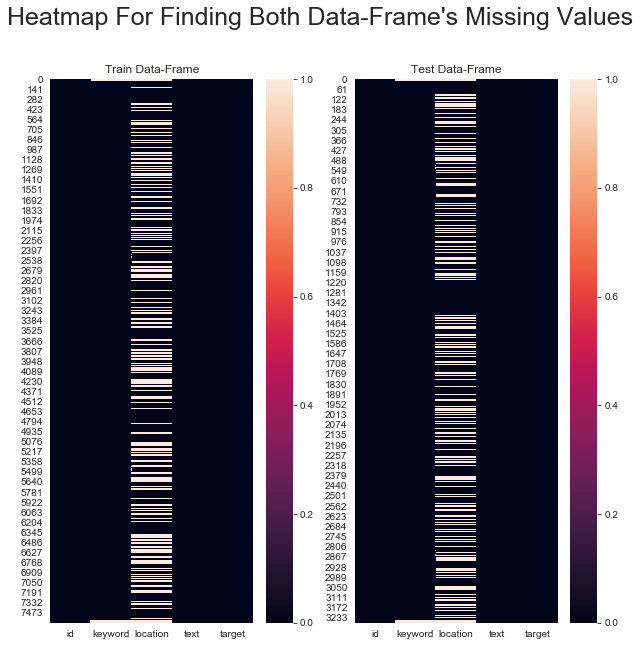

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10,10))
sns.heatmap(train.isnull(), ax=axes[0]).set_title("Train Data-Frame")
sns.heatmap(test.isnull(), ax=axes[1]).set_title("Test Data-Frame")

plt.suptitle("Heatmap For Finding Both Data-Frame's Missing Values", fontsize=25)
# plt.tight_layout()
plt.show()

**Through Heatmap** we can see that there are many **missing values** in **location column** of both **Train & Test Data** and a few are in **keyword column** as well.<br><br> We will handle them in **Data Cleaning part.**

# 3.2. Top 10 Locations From Both Data Tweet's :-

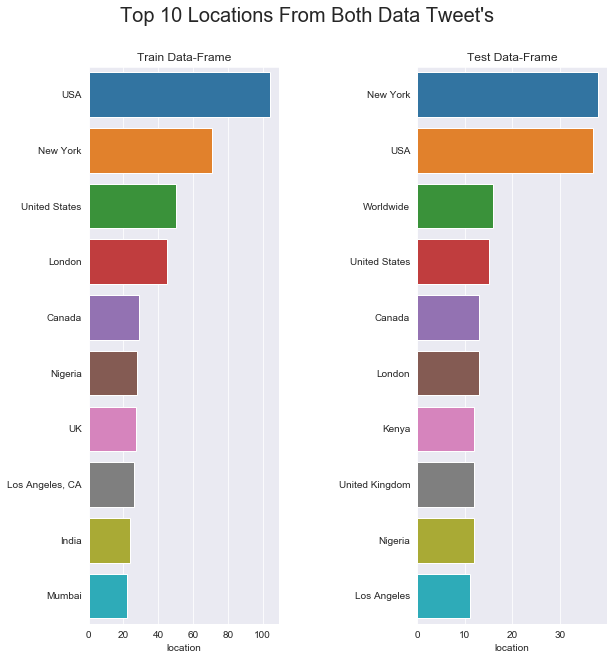

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10,10))
common_locations_train = train.location.value_counts()[:10]
common_locations_test = test.location.value_counts()[:10]
sns.barplot(x=common_locations_train, y=common_locations_train.index, ax=axes[0]).set_title("Train Data-Frame")
sns.barplot(x=common_locations_test, y=common_locations_test.index, ax=axes[1]).set_title("Test Data-Frame")
plt.suptitle("Top 10 Locations From Both Data Tweet's", fontsize=20)
plt.tight_layout(pad=6.0)
plt.show()

From the above diagram's we can see the most frequent locations from where the tweet's are actually posted on **Twitter** related to **Natural Disaster's**.<br><br>
And we can easily conclude that in both of the data-set's **New York**, **USA**, **United States** & **Canada** are in the Top Five List.

# 3.3. Data Cleaning :-

In [8]:
test = test.drop("location", axis=1)

# Droping the Missing Values 
test = test.dropna(axis=0)

# As Data's indexs are not in order so :
test = test.reset_index()

# Now, droping the old indexs as it became a column
test = test.drop("index", axis=1)
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3237 entries, 0 to 3236
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3237 non-null   int64 
 1   keyword  3237 non-null   object
 2   text     3237 non-null   object
 3   target   3237 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 101.3+ KB
None


,id,keyword,text,target
0,46,ablaze,Birmingham Wholesale Market is ablaze BBC News...,0
1,47,ablaze,@sunkxssedharry will you wear shorts for race ...,0
2,51,ablaze,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...,0
3,58,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
4,60,ablaze,PSA: IÛªm splitting my personalities.\n\n?? t...,0


As we saw above that the **location** column in **Test Data** has too much missing value's.<br><br>
So, I am **droping** that column because that column doesn't also help us in any way to possibly predict whether a tweet is talking about a **real disaster or not**.

In [9]:
train = train.drop("location", axis=1)

# Droping the Missing Values
train = train.dropna(axis=0)

# As Data's indexs are not in order so :
train = train.reset_index()

# Now, droping the old indexs as it became a column
train = train.drop("index", axis=1)
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7552 entries, 0 to 7551
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       7552 non-null   int64 
 1   keyword  7552 non-null   object
 2   text     7552 non-null   object
 3   target   7552 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 236.1+ KB
None


,id,keyword,text,target
0,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
1,49,ablaze,We always try to bring the heavy. #metal #RT h...,0
2,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
3,52,ablaze,Crying out for more! Set me ablaze,0
4,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


As we saw above that the **location** column in **Train Data** has too much missing value's.<br><br>
So, I am **droping** that column because that column doesn't also help us in any way to possibly predict whether a tweet is talking about a **real disaster or not**.

# 3.3.1. Distribution Of Classes :-

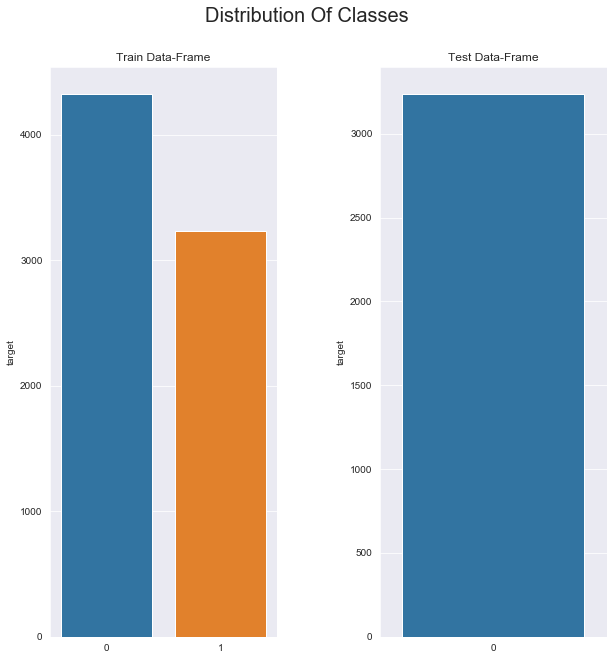

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10,10))
sns.barplot(x=train.target.value_counts().index, y=train.target.value_counts(), ax=axes[0]).set_title("Train Data-Frame")
sns.barplot(x=test.target.value_counts().index, y=test.target.value_counts(), ax=axes[1]).set_title("Test Data-Frame")
plt.suptitle("Distribution Of Classes", fontsize=20)
plt.tight_layout(pad=6.0)
plt.show()

Here we can see that our **classes are not much imbalanced** in **Train Data** & we can conclude that in our **Train Data only there are two classes like {0,1} whereas in our Test Data only 0 value target tweet's are stored.**<br><br>
We will handle that as well a little later after **Data Pre-Processing part.**

# 3.3.2. Top 10 Keywords From Both Data Tweet's :-

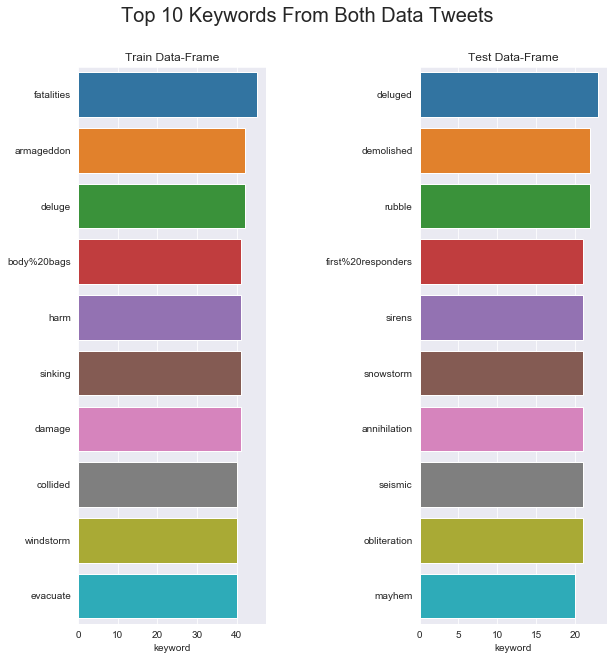

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10,10))
common_keywords_train = train.keyword.value_counts()[:10]
common_keywords_test = test.keyword.value_counts()[:10]
sns.barplot(x=common_keywords_train, y=common_keywords_train.index, ax=axes[0]).set_title("Train Data-Frame")
sns.barplot(x=common_keywords_test, y=common_keywords_test.index, ax=axes[1]).set_title("Test Data-Frame")
plt.suptitle("Top 10 Keywords From Both Data Tweets", fontsize=20)
plt.tight_layout(pad=6.0)
plt.show()

From the above diagram's we can easily notice that there are **barely 2 to 3 keywords** which are **common** in both data-set's **Top 10 Keywords List**.<br><br>
And these **Keywords** are even not playing any important role in predicting that whether a tweet is talking about a **real disaster or not**.

# 3.4. Data Pre-Processing :-

In [12]:
print(train.text[20])
print("="*100)
print(train.text[120])
print("="*100)
print(train.text[220])
print("="*100)
print(train.text[320])

Man wife get six years jail for setting ablaze niece
http://t.co/eV1ahOUCZA
Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on... http://t.co/TagZbcXFj0 #MLB
U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/sW1sBua3mN via @Change
One Direction Is my pick for http://t.co/q2eBlOKeVE Fan Army #Directioners http://t.co/eNCmhz6y34 x1411


**As** we can see here all the tweet's of **Train Data** are in a need of some **Polishing(Pre-Processing)** because there are various **stopwords, http:// tags & various punchuations** which aren't required while **predicting** that whether a **tweet** is talking about a **real disaster or not**.

In [13]:
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", "like", "via", "u", "video", "would", "one"]

Here is the **list of words** which are **most frequently** used in any **english paragraph** or in a **group of sentences**, and which **doesn't** play any important role in **creating a model to predict anything**.<br> **So**, we are simply naming them as **stopwords** and in the **following line of codes** I will be **removing these stopwords** from our **Data of Tweet's**.

In [14]:
# Pre_processing all the train data :-
lemmatizer = WordNetLemmatizer()
train.text = train.text.apply(lambda a: a.lower())
preprocessed_train = []
for sentence in tqdm(train.text.values):
    sentence = re.sub(r"http\S+", "", sentence)  # used for removing https links from sentences
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)  # removes punctuations
    
    sentence = ' '.join(lemmatizer.lemmatize(e) for e in sentence.split() if e not in stopwords)
    preprocessed_train.append(sentence.strip())

100%|██████████| 7552/7552 [00:08<00:00, 907.77it/s] 


The above line of code ***Pre-Processed*** all the ***Train Data*** and ***stored*** it all in a list named ***preprocessed_train***.

In [15]:
print(preprocessed_train[20])
print("="*100)
print(preprocessed_train[120])
print("="*100)
print(preprocessed_train[220])
print("="*100)
print(preprocessed_train[320])

man wife get six year jail setting ablaze niece
expert france begin examining airplane debris found reunion island french air accident expert mlb
national park service tonto national forest stop annihilation salt river wild horse change
direction pick fan army directioners


Now we can see all our **Train Data** is **cleaned** and **Pre-Processed**.

In [16]:
print(test.text[20])
print("="*100)
print(test.text[120])
print("="*100)
print(test.text[220])
print("="*100)
print(test.text[320])

@sakuma_en If you pretend to feel a certain way the feeling can become genuine all by accident. -Hei (Darker than Black) #manga #anime
Also my other nephew is proof that fat babies are going to save us from the apocalypse http://t.co/N5VImOqhBG
As you can imagine I had plenty to talk about with a maths teacher from Liverpool of a similar age into music !
@atlwtmgc damn this blew up


**As** we can see here all the tweet's of **Test Data** are in a need of some **Polishing(Pre-Processing)** because there are various **stopwords, http:// tags & various punchuations** which aren't required while **predicting** that whether a **tweet** is talking about a **real disaster or not**.

In [1]:
# Pre_processing all the test data :-
test.text = test.text.apply(lambda a: a.lower())
preprocessed_test = []
for sentence in tqdm(test.text.values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    
    sentence = ' '.join(lemmatizer.lemmatize(e) for e in sentence.split() if e not in stopwords)
    preprocessed_test.append(sentence.strip())

NameError: name 'test' is not defined

The above line of code ***Pre-Processed*** all the ***Test Data*** and ***stored*** it all in a list named ***preprocessed_test***.

In [18]:
print(preprocessed_test[20])
print("="*100)
print(preprocessed_test[120])
print("="*100)
print(preprocessed_test[220])
print("="*100)
print(preprocessed_test[320])

sakuma en pretend feel certain way feeling become genuine accident hei darker black manga anime
also nephew proof fat baby going save u apocalypse
imagine plenty talk math teacher liverpool similar age music
atlwtmgc damn blew


Now we can see all our **Test Data** is **cleaned** and **Pre-Processed**.

In [19]:
# Converting preprocessed_train List into a Series to join it back in Train Data : 
final_text_train = pd.Series(preprocessed_train)
final_text_train.name = "final_text"

# Joining Train Data with preprocessed_train Series & droping the old text(Tweet) column :
train = pd.DataFrame.join(train, final_text_train)
train = train.drop("text", axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7552 entries, 0 to 7551
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7552 non-null   int64 
 1   keyword     7552 non-null   object
 2   target      7552 non-null   int64 
 3   final_text  7552 non-null   object
dtypes: int64(2), object(2)
memory usage: 236.1+ KB


In [20]:
# Converting preprocessed_test List into a Series to join it back in Test Data :
final_text_test = pd.Series(preprocessed_test)
final_text_test.name = "final_text"

# Joining Test Data with preprocessed_test Series & droping the old text(Tweet) column :
test = pd.DataFrame.join(test, final_text_test)
test = test.drop("text", axis=1)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3237 entries, 0 to 3236
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3237 non-null   int64 
 1   keyword     3237 non-null   object
 2   target      3237 non-null   int64 
 3   final_text  3237 non-null   object
dtypes: int64(2), object(2)
memory usage: 101.3+ KB


# 3.4.1. Creating Final Data-Frame (Inclusive Of Train & Test Both):-

In [21]:
df = train.append(test, ignore_index=True)

# Id & Keyword columns are not of any use for Creating Model or for any Prediction's :
df = df.drop(["id", "keyword"], axis=1)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   target      10789 non-null  int64 
 1   final_text  10789 non-null  object
dtypes: int64(1), object(1)
memory usage: 168.7+ KB
None


,target,final_text
0,1,bbcmtd wholesale market ablaze
1,0,always try bring heavy metal rt
2,1,africanbaze breaking news nigeria flag set abl...
3,0,cry set ablaze
4,0,plus side look sky last night ablaze


In [22]:
print('Now there are {} rows & {} columns in train.'.format(train.shape[0],train.shape[1]))
print('Now there are {} rows & {} columns in test.'.format(test.shape[0],test.shape[1]))
print('Now there are {} rows & {} columns in df(The Final Data-Frame).'.format(df.shape[0],df.shape[1]))

Now there are 7552 rows & 4 columns in train.
Now there are 3237 rows & 4 columns in test.
Now there are 10789 rows & 2 columns in df(The Final Data-Frame).


**Now** there are **7552 rows** & **4 columns** in **train**.<br>
**Now** there are **3237 rows** & **4 columns** in **test**.<br><br>
**And** there are **10789 rows** & **2 columns** in **df(The Final Data-Frame)**.

# 3.4.2. Top 15 Frequent Words In Tweet's :-

In [23]:
words = []
for sentences in tqdm(df.final_text.values):
    sentences = "".join(sentences.lower())
    words.append(sentences)
words = ''.join(word for word in words)
words = nltk.word_tokenize(words)
words = pd.Series(words)

100%|██████████| 10789/10789 [00:00<00:00, 225001.72it/s]


In the above line of code as we want to **plot a barplot** of some of the **most frequent words** in our whole **Data of Tweet's**.<br> **First** we will have to **join all the tweet's** with **lowering all the words and alphabet's** so that our system will easily find out the **words** which are **most frequently repeated**.<br> **Second**, we will have to **convert all the tweets** to **single-single words** to know the **frequency** of them, this can be done by using **nltk.word_tokenize()** and in the **last** we will convert all **single-single words** from a **list** to a **column** to apply a function called **value_counts()**.

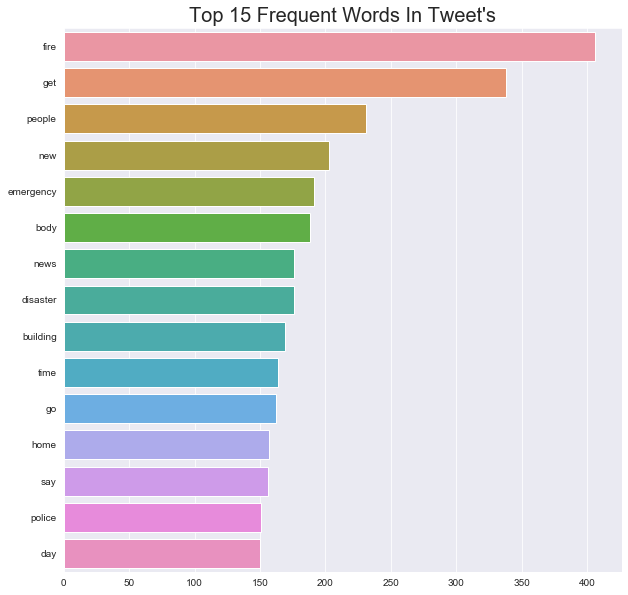

In [24]:
plt.figure(figsize=(10,10))
sns.barplot(x=words.value_counts()[:15], y=words.value_counts()[:15].index)
plt.title("Top 15 Frequent Words In Tweet's", fontsize=20)
plt.show()

So, we can see here the **words** which are widely used in our **Data of Tweet's**.

# 4. Spliting Final Data-Frame Into Train, Cross-Validation,  Test :-

In [25]:
# Defining Input & Output :
X = df["final_text"]
y = df["target"]

# Spliting Final Data-Frame Into Train, Cross-Validation, Test :
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.2)

Here I have used **train_test_split()** function to **break** my **Data of Tweet's** into **3 categories equally proportional to each class {0,1}** namely **:-**<br> {**Train** (For Training the Model), **Cross-Validation** (For cross checking the predictions) **&** **Test** (For final testing of our model)}.

# 4.1. Equal Distribution Of Classes :-

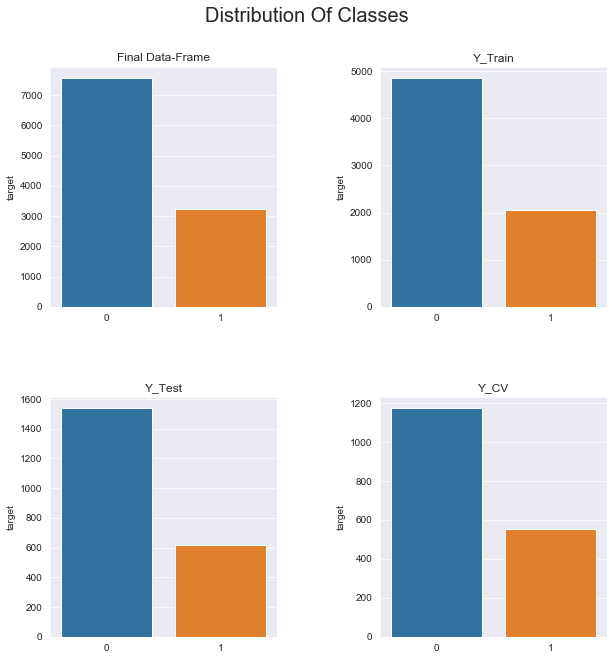

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
sns.barplot(x=df.target.value_counts().index, y=df.target.value_counts(), ax=axes[0,0]).set_title("Final Data-Frame")
sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts(), ax=axes[0,1]).set_title("Y_Train")
sns.barplot(x=y_cv.value_counts().index, y=y_cv.value_counts(), ax=axes[1,1]).set_title("Y_CV")
sns.barplot(x=y_test.value_counts().index, y=y_test.value_counts(), ax=axes[1,0]).set_title("Y_Test")
plt.suptitle("Distribution Of Classes", fontsize=20)
plt.tight_layout(pad=6.0)
plt.show()

As we can see above all the **3 categories** are now having **equal proportion of {0,1} Classes.**<br><br>
This tells us that now our **Data** is all set to go for **Featurization** & then for **Creating Model by various Algorithms**.

In [27]:
print("Length Of X_train :-", X_train.shape[0])
print("Length Of y_train :-", y_train.shape[0])
print("Length Of X_test :-", X_test.shape[0])
print("Length Of y_test :-", y_test.shape[0])
print("Length Of X_cv :-", X_cv.shape[0])
print("Length Of y_cv :-", y_cv.shape[0])

Length Of X_train :- 6904
Length Of y_train :- 6904
Length Of X_test :- 2158
Length Of y_test :- 2158
Length Of X_cv :- 1727
Length Of y_cv :- 1727


# 5. Featurization & Applying Algorithms :- 


***Following are the parts of my Featurization & Applying Algorithms section :-***<br>
# 5.1.
In this part I am going to convert all my **Tweet's text Data into Vectors** using **Bag-Of-Words** represented by **bow** and then will apply following **Algorithms :-**<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;**5.1.1.** - **First** will apply **Logistic Regression** which is **represented** here by **log**.<br>
&nbsp;&nbsp;&nbsp;&nbsp;**5.1.2.** - **Second** will apply **Multi-Nomial Naive Bayes** which is **represented** here by **mnb**.<br>
&nbsp;&nbsp;&nbsp;&nbsp;**5.1.3.** - **Third** will apply **Decision-Tree Classifier** which is **represented** here by **dtc**.<br>
&nbsp;&nbsp;&nbsp;&nbsp;**5.1.4.** - **Fourth** there will be **Comaprison of Bag-Of-Words Test's** {To **find out** which **Algorithm** worked **best with Bag-Of-Words**}.

# 5.2.
In this part I am going to convert all my **Tweet's text Data into Vectors** using **TF-IDF (Term Frequency - Inverse Document Frequency)** represented by **tfidf** and then will apply following **Algorithms :-**<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;**5.2.1.** - **First** will apply **Logistic Regression** which is **represented** here by **log**.<br>
&nbsp;&nbsp;&nbsp;&nbsp;**5.2.2.** - **Second** will apply **Multi-Nomial Naive Bayes** which is **represented** here by **mnb**.<br>
&nbsp;&nbsp;&nbsp;&nbsp;**5.2.3.** - **Third** will apply **Decision-Tree Classifier** which is **represented** here by **dtc**.<br>
&nbsp;&nbsp;&nbsp;&nbsp;**5.2.4.** - **Fourth** there will be **Comaprison of TF-IDF Test's** {To **find out** which **Algorithm** worked **best with TF-IDF**}.

# 5.3
Here in **Final Comparison** I will compare all the **selected Algorithms** which i will get from **both Featurization techniques {Bag-Of-Words & TF-IDF}** by **ROC & AUC Curve's**.

# 5.4
Now comes the **Conclusion** part where I will create a **Conclusion Table** with the help of **prettytable library** and will show the **results** of all of the **Algorithms** to **easily compare**.

# 5.1. - Bag Of Words :-

In [28]:
bow = CountVectorizer(ngram_range=(1,2), min_df=2)
X_train_bow = bow.fit_transform(X_train).toarray()
X_cv_bow = bow.transform(X_cv).toarray()
X_test_bow = bow.transform(X_test).toarray()

Here I have used **Bag-Of-Words** for **converting** all the **tweet's** from **text** to **vectors**. 

# 5.1.1. - Logisctic Regression :-

In [29]:
log = LogisticRegression()
log.fit(X_train_bow, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
pre_cv_bow_log = log.predict(X_cv_bow)
pre_test_bow_log = log.predict(X_test_bow)

After **training the model** with the help of **Bow & Logistic Regression** here in the above line of code I have stored **predictions** of **Cross-Validation & Test Data** for **further analysis**.

In [31]:
print("BOW CV Classification Report by Logistic Regression")
print(classification_report(y_cv, pre_cv_bow_log))
print("="*100)
print("BOW Test Classification Report by Logistic Regression")
print(classification_report(y_test, pre_test_bow_log))

BOW CV Classification Report by Logistic Regression
              precision    recall  f1-score   support

           0       0.76      0.90      0.82      1174
           1       0.65      0.40      0.49       553

    accuracy                           0.74      1727
   macro avg       0.70      0.65      0.66      1727
weighted avg       0.72      0.74      0.72      1727

BOW Test Classification Report by Logistic Regression
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1538
           1       0.57      0.44      0.50       620

    accuracy                           0.74      2158
   macro avg       0.68      0.65      0.66      2158
weighted avg       0.73      0.74      0.73      2158



We can see many things from above **Classification Report's** like **Precision**, **Recall**, **F1-score**, **Accuracy** of both the predictions which we got from **Cross-Validation & Test data**.

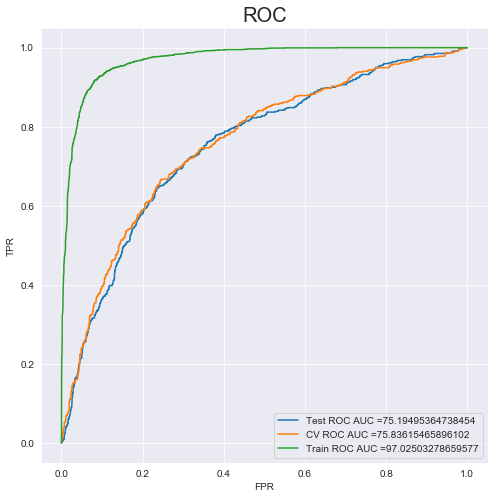

In [32]:
preproba_cv_bow_log = log.predict_proba(X_cv_bow)[:,1]
preproba_test_bow_log = log.predict_proba(X_test_bow)[:,1]
preproba_train_bow_log = log.predict_proba(X_train_bow)[:,1]

fpr_cv_bow_log_roc, tpr_cv_bow_log_roc, threshold_cv_bow_log_roc = roc_curve(y_cv, preproba_cv_bow_log)
fpr_test_bow_log_roc, tpr_test_bow_log_roc, threshold_test_bow_log_roc = roc_curve(y_test, preproba_test_bow_log)
fpr_train_bow_log_roc, tpr_train_bow_log_roc, threshold_train_bow_log_roc = roc_curve(y_train, preproba_train_bow_log)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr_test_bow_log_roc,tpr_test_bow_log_roc, label='Test ROC AUC ='+str(roc_auc_score(y_test,preproba_test_bow_log)*100))
ax.plot(fpr_cv_bow_log_roc, tpr_cv_bow_log_roc, label='CV ROC AUC ='+str(roc_auc_score(y_cv, preproba_cv_bow_log)*100))
ax.plot(fpr_train_bow_log_roc,tpr_train_bow_log_roc, label='Train ROC AUC ='+str(roc_auc_score(y_train,preproba_train_bow_log)*100))
plt.title('ROC', fontsize=20)
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()



In the above line of code we plotted **Receiver Operating Characteristic (ROC) Curve** on all the **threshold's** possible and then drew this above diagram from **Test, Train and Cross-Validation Data**.

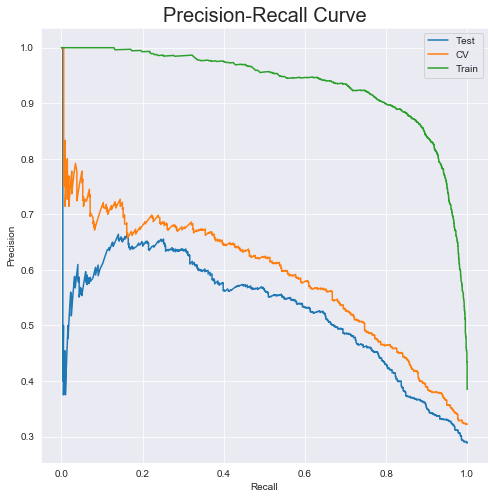

In [33]:
precision_test_bow_log_pr, recall_test_bow_log_pr, threshold_test_bow_log_pr = precision_recall_curve(y_test, preproba_test_bow_log)
precision_cv_bow_log_pr, recall_cv_bow_log_pr, threshold_cv_bow_log_pr = precision_recall_curve(y_cv, preproba_cv_bow_log)
precision_train_bow_log_pr, recall_train_bow_log_pr, threshold_train_bow_log_pr = precision_recall_curve(y_train, preproba_train_bow_log)
fig_1 = plt.figure()
ax_1 = plt.subplot(111)
ax_1.plot(recall_test_bow_log_pr, precision_test_bow_log_pr, label="Test")
ax_1.plot(recall_cv_bow_log_pr, precision_cv_bow_log_pr, label="CV")
ax_1.plot(recall_train_bow_log_pr, precision_train_bow_log_pr, label="Train")
plt.title('Precision-Recall Curve', fontsize=20)
plt.xlabel('Recall')
plt.ylabel('Precision')
ax_1.legend()
plt.show()

In the above line of code we plotted **Precision-Recall Curve** from **Test, Train and Cross-Validation Data**.

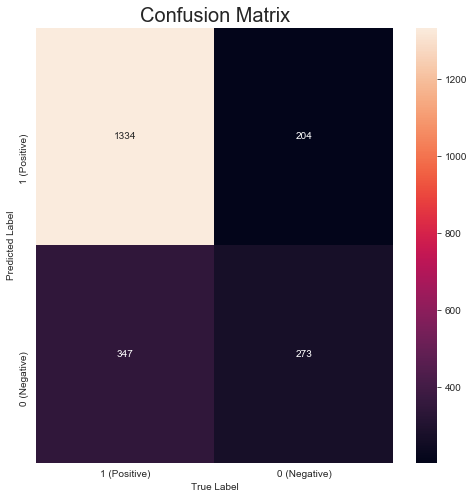

In [34]:
conf_test_bow_log = confusion_matrix(y_test, pre_test_bow_log)
class_label = ["1 (Positive)", "0 (Negative)"]
df = pd.DataFrame(conf_test_bow_log, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix", fontsize=20)
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()


# 5.1.2. - Naive Bayes {Multi-Nomial Naive Bayes}:-

In [35]:
mnb = MultinomialNB()
mnb.fit(X_train_bow, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [36]:
pre_cv_bow_mnb = mnb.predict(X_cv_bow)
pre_test_bow_mnb = mnb.predict(X_test_bow)

After **training the model** with the help of **Bow & Multi-Nomial Naive Bayes** here in the above line of code I have stored **predictions** of **Cross-Validation & Test Data** for **further analysis**.

In [37]:
print("BOW CV Classification Report by Multi-Nomial Naiye Bayes")
print(classification_report(y_cv, pre_cv_bow_mnb))
print("="*100)
print("BOW Test Classification Report by Multi-Nomial Naiye Bayes")
print(classification_report(y_test, pre_test_bow_mnb))

BOW CV Classification Report by Multi-Nomial Naiye Bayes
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1174
           1       0.66      0.51      0.57       553

    accuracy                           0.76      1727
   macro avg       0.73      0.69      0.70      1727
weighted avg       0.75      0.76      0.75      1727

BOW Test Classification Report by Multi-Nomial Naiye Bayes
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1538
           1       0.60      0.54      0.57       620

    accuracy                           0.76      2158
   macro avg       0.71      0.70      0.70      2158
weighted avg       0.76      0.76      0.76      2158



We can see many things from above **Classification Report's** like **Precision**, **Recall**, **F1-score**, **Accuracy** of both the predictions which we got from **Cross-Validation & Test data**.

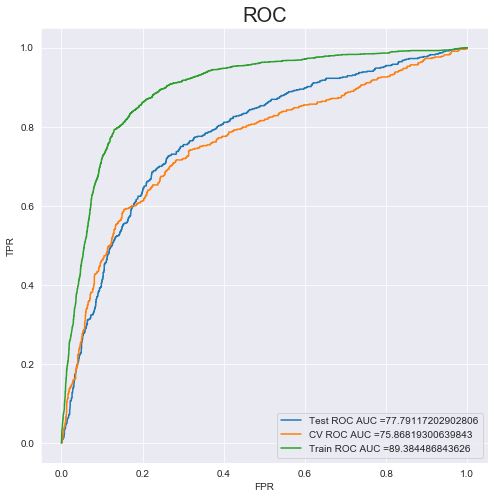

In [38]:
preproba_cv_bow_mnb = mnb.predict_proba(X_cv_bow)[:,1]
preproba_test_bow_mnb = mnb.predict_proba(X_test_bow)[:,1]
preproba_train_bow_mnb = mnb.predict_proba(X_train_bow)[:,1]

fpr_cv_bow_mnb_roc, tpr_cv_bow_mnb_roc, threshold_cv_bow_mnb_roc = roc_curve(y_cv, preproba_cv_bow_mnb)
fpr_test_bow_mnb_roc, tpr_test_bow_mnb_roc, threshold_test_bow_mnb_roc = roc_curve(y_test, preproba_test_bow_mnb)
fpr_train_bow_mnb_roc, tpr_train_bow_mnb_roc, threshold_train_bow_mnb_roc = roc_curve(y_train, preproba_train_bow_mnb)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr_test_bow_mnb_roc,tpr_test_bow_mnb_roc, label='Test ROC AUC ='+str(roc_auc_score(y_test,preproba_test_bow_mnb)*100))
ax.plot(fpr_cv_bow_mnb_roc, tpr_cv_bow_mnb_roc, label='CV ROC AUC ='+str(roc_auc_score(y_cv, preproba_cv_bow_mnb)*100))
ax.plot(fpr_train_bow_mnb_roc, tpr_train_bow_mnb_roc, label='Train ROC AUC ='+str(roc_auc_score(y_train, preproba_train_bow_mnb)*100))
plt.title('ROC', fontsize=20)
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

In the above line of code we plotted **Receiver Operating Characteristic (ROC) Curve** on all the **threshold's** possible and then drew this above diagram from **Test, Train and Cross-Validation Data**.

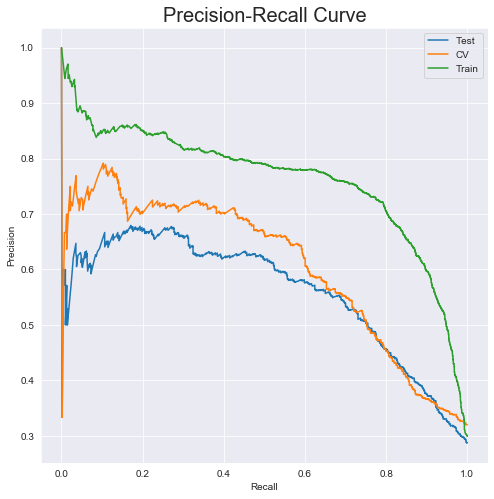

In [39]:
precision_test_bow_mnb_pr, recall_test_bow_mnb_pr, threshold_test_bow_mnb_pr = precision_recall_curve(y_test, preproba_test_bow_mnb)
precision_cv_bow_mnb_pr, recall_cv_bow_mnb_pr, threshold_cv_bow_mnb_pr = precision_recall_curve(y_cv, preproba_cv_bow_mnb)
precision_train_bow_mnb_pr, recall_train_bow_mnb_pr, threshold_train_bow_mnb_pr = precision_recall_curve(y_train, preproba_train_bow_mnb)
fig_1 = plt.figure()
ax_1 = plt.subplot(111)
ax_1.plot(recall_test_bow_mnb_pr, precision_test_bow_mnb_pr, label="Test")
ax_1.plot(recall_cv_bow_mnb_pr, precision_cv_bow_mnb_pr, label="CV")
ax_1.plot(recall_train_bow_mnb_pr, precision_train_bow_mnb_pr, label="Train")
plt.title('Precision-Recall Curve', fontsize=20)
plt.xlabel('Recall')
plt.ylabel('Precision')
ax_1.legend()
plt.show()

In the above line of code we plotted **Precision-Recall Curve** from **Test, Train and Cross-Validation Data**.

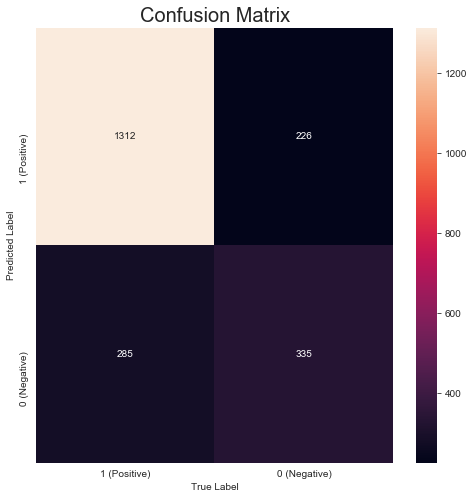

In [40]:
conf_test_bow_mnb = confusion_matrix(y_test, pre_test_bow_mnb)
class_label = ["1 (Positive)", "0 (Negative)"]
df = pd.DataFrame(conf_test_bow_mnb, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix", fontsize=20)
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()


# 5.1.3. - Decision-Tree Classifier :-

In [41]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_bow, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [42]:
pre_cv_bow_dtc = dtc.predict(X_cv_bow)
pre_test_bow_dtc = dtc.predict(X_test_bow)

After **training the model** with the help of **Bow & Decision-Tree Classifier** here in the above line of code I have stored **predictions** of **Cross-Validation & Test Data** for **further analysis**.

In [43]:
print("BOW CV Classification Report by Decision-Tree Classifier")
print(classification_report(y_cv, pre_cv_bow_dtc))
print("="*100)
print("BOW Test Classification Report by Decision-Tree Classifier")
print(classification_report(y_test, pre_test_bow_dtc))

BOW CV Classification Report by Decision-Tree Classifier
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1174
           1       0.60      0.44      0.51       553

    accuracy                           0.73      1727
   macro avg       0.68      0.65      0.66      1727
weighted avg       0.71      0.73      0.71      1727

BOW Test Classification Report by Decision-Tree Classifier
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1538
           1       0.49      0.44      0.47       620

    accuracy                           0.71      2158
   macro avg       0.64      0.63      0.63      2158
weighted avg       0.70      0.71      0.70      2158



We can see many things from above **Classification Report's** like **Precision**, **Recall**, **F1-score**, **Accuracy** of both the predictions which we got from **Cross-Validation & Test Data**.

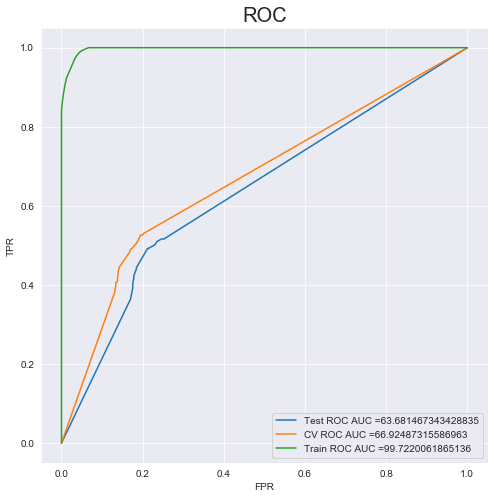

In [44]:
preproba_cv_bow_dtc = dtc.predict_proba(X_cv_bow)[:,1]
preproba_test_bow_dtc = dtc.predict_proba(X_test_bow)[:,1]
preproba_train_bow_dtc = dtc.predict_proba(X_train_bow)[:,1]

fpr_cv_bow_dtc_roc, tpr_cv_bow_dtc_roc, threshold_cv_bow_dtc_roc = roc_curve(y_cv, preproba_cv_bow_dtc)
fpr_test_bow_dtc_roc, tpr_test_bow_dtc_roc, threshold_test_bow_dtc_roc = roc_curve(y_test, preproba_test_bow_dtc)
fpr_train_bow_dtc_roc, tpr_train_bow_dtc_roc, threshold_train_bow_dtc_roc = roc_curve(y_train, preproba_train_bow_dtc)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr_test_bow_dtc_roc,tpr_test_bow_dtc_roc, label='Test ROC AUC ='+str(roc_auc_score(y_test,preproba_test_bow_dtc)*100))
ax.plot(fpr_cv_bow_dtc_roc, tpr_cv_bow_dtc_roc, label='CV ROC AUC ='+str(roc_auc_score(y_cv, preproba_cv_bow_dtc)*100))
ax.plot(fpr_train_bow_dtc_roc, tpr_train_bow_dtc_roc, label='Train ROC AUC ='+str(roc_auc_score(y_train, preproba_train_bow_dtc)*100))
plt.title('ROC', fontsize=20)
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

In the above line of code we plotted **Receiver Operating Characteristic (ROC) Curve** on all the **threshold's** possible and then drew this above diagram from **Test, Train and Cross-Validation Data**.

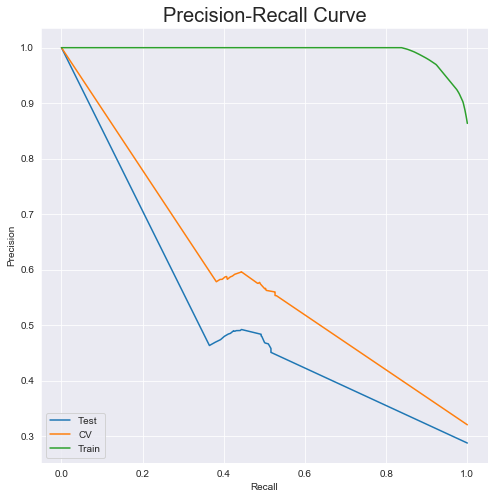

In [45]:
precision_test_bow_dtc_pr, recall_test_bow_dtc_pr, threshold_test_bow_dtc_pr = precision_recall_curve(y_test, preproba_test_bow_dtc)
precision_cv_bow_dtc_pr, recall_cv_bow_dtc_pr, threshold_cv_bow_dtc_pr = precision_recall_curve(y_cv, preproba_cv_bow_dtc)
precision_train_bow_dtc_pr, recall_train_bow_dtc_pr, threshold_train_bow_dtc_pr = precision_recall_curve(y_train, preproba_train_bow_dtc)
fig_1 = plt.figure()
ax_1 = plt.subplot(111)
ax_1.plot(recall_test_bow_dtc_pr, precision_test_bow_dtc_pr, label="Test")
ax_1.plot(recall_cv_bow_dtc_pr, precision_cv_bow_dtc_pr, label="CV")
ax_1.plot(recall_train_bow_dtc_pr, precision_train_bow_dtc_pr, label="Train")
plt.title('Precision-Recall Curve', fontsize=20)
plt.xlabel('Recall')
plt.ylabel('Precision')
ax_1.legend()
plt.show()

In the above line of code we plotted **Precision-Recall Curve** from **Test, Train and Cross-Validation Data**.

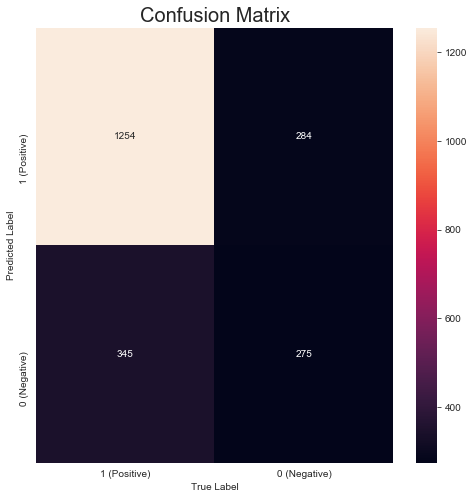

In [46]:
conf_test_bow_dtc = confusion_matrix(y_test, pre_test_bow_dtc)
class_label = ["1 (Positive)", "0 (Negative)"]
df = pd.DataFrame(conf_test_bow_dtc, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix", fontsize=20)
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

# 5.1.4. - Comaprison of Bag Of Words Test's :-

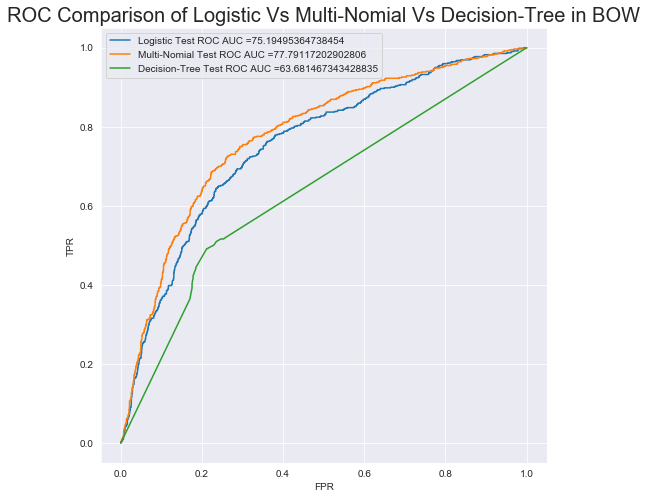

In [47]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr_test_bow_log_roc,tpr_test_bow_log_roc, label='Logistic Test ROC AUC ='+str(roc_auc_score(y_test,preproba_test_bow_log)*100))
ax.plot(fpr_test_bow_mnb_roc,tpr_test_bow_mnb_roc, label='Multi-Nomial Test ROC AUC ='+str(roc_auc_score(y_test,preproba_test_bow_mnb)*100))
ax.plot(fpr_test_bow_dtc_roc,tpr_test_bow_dtc_roc, label='Decision-Tree Test ROC AUC ='+str(roc_auc_score(y_test,preproba_test_bow_dtc)*100))
plt.title('ROC Comparison of Logistic Vs Multi-Nomial Vs Decision-Tree in BOW', fontsize=20)
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

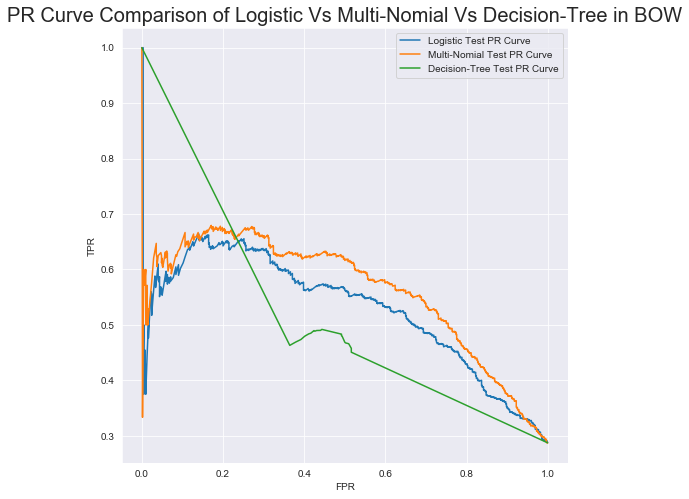

In [48]:
fig = plt.figure()
ax_1 = plt.subplot(111)
ax_1.plot(recall_test_bow_log_pr, precision_test_bow_log_pr, label="Logistic Test PR Curve")
ax_1.plot(recall_test_bow_mnb_pr, precision_test_bow_mnb_pr, label="Multi-Nomial Test PR Curve")
ax_1.plot(recall_test_bow_dtc_pr, precision_test_bow_dtc_pr, label="Decision-Tree Test PR Curve")
plt.title('PR Curve Comparison of Logistic Vs Multi-Nomial Vs Decision-Tree in BOW', fontsize=20)
plt.xlabel('FPR')
plt.ylabel('TPR')
ax_1.legend()
plt.show()

# 5.2. - TF-IDF :-

In [49]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_cv_tfidf = tfidf.transform(X_cv).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

Here I have used **TF-IDF (Term Frequency - Inverse Term Frequency)** for **converting** all the **tweet's** from **text** to **vectors**. 

# 5.2.1. - Logisctic Regression :-

In [50]:
log = LogisticRegression()
log.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
pre_cv_tfidf_log = log.predict(X_cv_tfidf)
pre_test_tfidf_log = log.predict(X_test_tfidf)

After **training the model** with the help of **TF-IDF & Logistic Regression** here in the above line of code I have stored **predictions** of **Cross-Validation & Test Data** for **further analysis**.

In [52]:
print("TF-IDF CV Classification Report by Logistic Regresion")
print(classification_report(y_cv, pre_cv_tfidf_log))
print("="*100)
print("TF-IDF Test Classification Report by Logistic Regresion")
print(classification_report(y_test, pre_test_tfidf_log))

TF-IDF CV Classification Report by Logistic Regresion
              precision    recall  f1-score   support

           0       0.74      0.94      0.83      1174
           1       0.70      0.31      0.43       553

    accuracy                           0.74      1727
   macro avg       0.72      0.62      0.63      1727
weighted avg       0.73      0.74      0.70      1727

TF-IDF Test Classification Report by Logistic Regresion
              precision    recall  f1-score   support

           0       0.77      0.91      0.84      1538
           1       0.61      0.33      0.43       620

    accuracy                           0.75      2158
   macro avg       0.69      0.62      0.64      2158
weighted avg       0.73      0.75      0.72      2158



We can see many things from above **Classification Report's** like **Precision**, **Recall**, **F1-score**, **Accuracy** of both the predictions which we got from **Cross-Validation & Test data**.

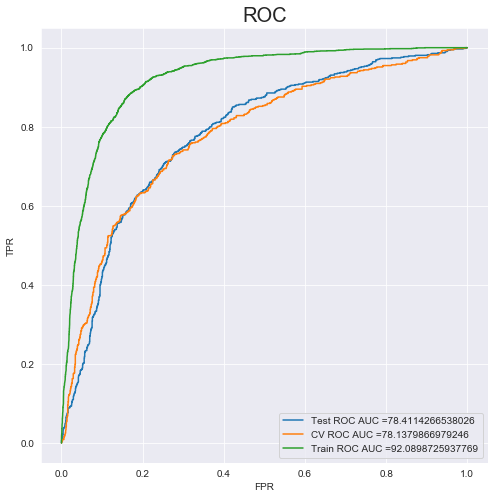

In [53]:
preproba_cv_tfidf_log = log.predict_proba(X_cv_tfidf)[:,1]
preproba_test_tfidf_log = log.predict_proba(X_test_tfidf)[:,1]
preproba_train_tfidf_log = log.predict_proba(X_train_tfidf)[:,1]

fpr_cv_tfidf_log_roc, tpr_cv_tfidf_log_roc, threshold_cv_tfidf_log_roc = roc_curve(y_cv, preproba_cv_tfidf_log)
fpr_test_tfidf_log_roc, tpr_test_tfidf_log_roc, threshold_test_tfidf_log_roc = roc_curve(y_test, preproba_test_tfidf_log)
fpr_train_tfidf_log_roc, tpr_train_tfidf_log_roc, threshold_train_tfidf_log_roc = roc_curve(y_train, preproba_train_tfidf_log)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr_test_tfidf_log_roc,tpr_test_tfidf_log_roc, label='Test ROC AUC ='+str(roc_auc_score(y_test,preproba_test_tfidf_log)*100))
ax.plot(fpr_cv_tfidf_log_roc, tpr_cv_tfidf_log_roc, label='CV ROC AUC ='+str(roc_auc_score(y_cv, preproba_cv_tfidf_log)*100))
ax.plot(fpr_train_tfidf_log_roc,tpr_train_tfidf_log_roc, label='Train ROC AUC ='+str(roc_auc_score(y_train,preproba_train_tfidf_log)*100))
plt.title('ROC', fontsize=20)
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

In the above line of code we plotted **Receiver Operating Characteristic (ROC) Curve** on all the **threshold's** possible and then drew this above diagram from **Test, Train and Cross-Validation Data**.

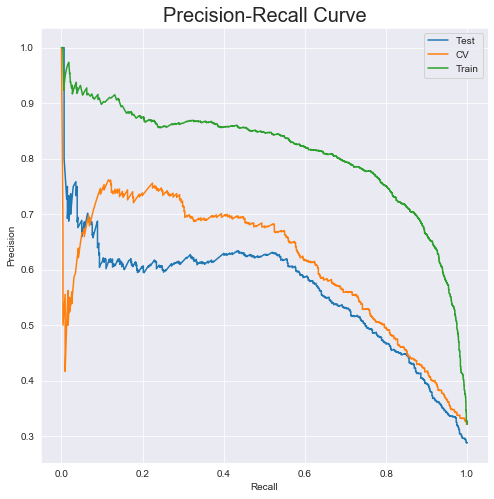

In [54]:
precision_test_tfidf_log_pr, recall_test_tfidf_log_pr, threshold_test_tfidf_log_pr = precision_recall_curve(y_test, preproba_test_tfidf_log)
precision_cv_tfidf_log_pr, recall_cv_tfidf_log_pr, threshold_cv_tfidf_log_pr = precision_recall_curve(y_cv, preproba_cv_tfidf_log)
precision_train_tfidf_log_pr, recall_train_tfidf_log_pr, threshold_train_tfidf_log_pr = precision_recall_curve(y_train, preproba_train_tfidf_log)
fig_1 = plt.figure()
ax_1 = plt.subplot(111)
ax_1.plot(recall_test_tfidf_log_pr, precision_test_tfidf_log_pr, label="Test")
ax_1.plot(recall_cv_tfidf_log_pr, precision_cv_tfidf_log_pr, label="CV")
ax_1.plot(recall_train_tfidf_log_pr, precision_train_tfidf_log_pr, label="Train")
plt.title('Precision-Recall Curve', fontsize=20)
plt.xlabel('Recall')
plt.ylabel('Precision')
ax_1.legend()
plt.show()

In the above line of code we plotted **Precision-Recall Curve** from **Test, Train and Cross-Validation Data**.

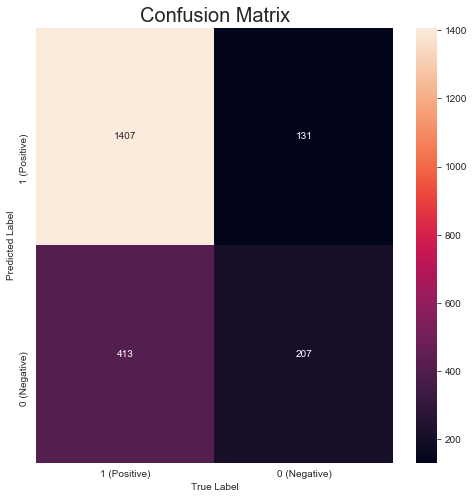

In [55]:
conf_test_tfidf_log = confusion_matrix(y_test, pre_test_tfidf_log)
class_label = ["1 (Positive)", "0 (Negative)"]
df = pd.DataFrame(conf_test_tfidf_log, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix", fontsize=20)
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()


# 5.2.2. - Naive Bayes {Multi-Nomial Naive Bayes} :-

In [56]:
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [57]:
pre_cv_tfidf_mnb = mnb.predict(X_cv_tfidf)
pre_test_tfidf_mnb = mnb.predict(X_test_tfidf)

After **training the model** with the help of **TF-IDF & Multi-Nomial Naive Bayes** here in the above line of code I have stored **predictions** of **Cross-Validation & Test Data** for **further analysis**.

In [58]:
print("TF-IDF CV Classification Report by Multi-Nomial Naive Bayes")
print(classification_report(y_cv, pre_cv_tfidf_mnb))
print("="*100)
print("TF-IDF Test Classification Report by Multi-Nomial Naive Bayes")
print(classification_report(y_test, pre_test_tfidf_mnb))

TF-IDF CV Classification Report by Multi-Nomial Naive Bayes
              precision    recall  f1-score   support

           0       0.74      0.94      0.83      1174
           1       0.72      0.31      0.43       553

    accuracy                           0.74      1727
   macro avg       0.73      0.63      0.63      1727
weighted avg       0.73      0.74      0.70      1727

TF-IDF Test Classification Report by Multi-Nomial Naive Bayes
              precision    recall  f1-score   support

           0       0.78      0.92      0.84      1538
           1       0.63      0.35      0.45       620

    accuracy                           0.75      2158
   macro avg       0.70      0.63      0.64      2158
weighted avg       0.73      0.75      0.73      2158



We can see many things from above **Classification Report's** like **Precision**, **Recall**, **F1-score**, **Accuracy** of both the predictions which we got from **Cross-Validation & Test data**.

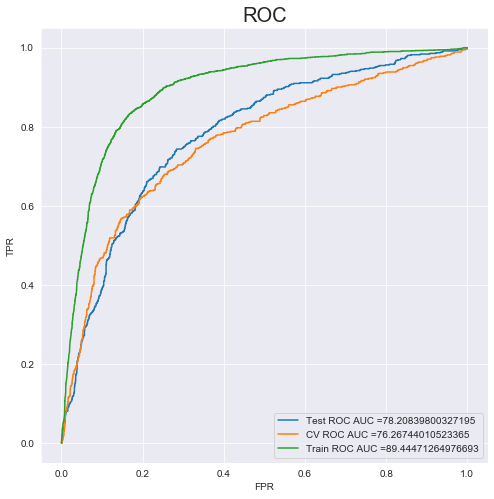

In [59]:
preproba_cv_tfidf_mnb = mnb.predict_proba(X_cv_tfidf)[:,1]
preproba_test_tfidf_mnb = mnb.predict_proba(X_test_tfidf)[:,1]
preproba_train_tfidf_mnb = mnb.predict_proba(X_train_tfidf)[:,1]

fpr_cv_tfidf_mnb_roc, tpr_cv_tfidf_mnb_roc, threshold_cv_tfidf_mnb_roc = roc_curve(y_cv, preproba_cv_tfidf_mnb)
fpr_test_tfidf_mnb_roc, tpr_test_tfidf_mnb_roc, threshold_test_tfidf_mnb_roc = roc_curve(y_test, preproba_test_tfidf_mnb)
fpr_train_tfidf_mnb_roc, tpr_train_tfidf_mnb_roc, threshold_train_tfidf_mnb_roc = roc_curve(y_train, preproba_train_tfidf_mnb)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr_test_tfidf_mnb_roc,tpr_test_tfidf_mnb_roc, label='Test ROC AUC ='+str(roc_auc_score(y_test,preproba_test_tfidf_mnb)*100))
ax.plot(fpr_cv_tfidf_mnb_roc, tpr_cv_tfidf_mnb_roc, label='CV ROC AUC ='+str(roc_auc_score(y_cv, preproba_cv_tfidf_mnb)*100))
ax.plot(fpr_train_tfidf_mnb_roc,tpr_train_tfidf_mnb_roc, label='Train ROC AUC ='+str(roc_auc_score(y_train,preproba_train_tfidf_mnb)*100))
plt.title('ROC', fontsize=20)
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

In the above line of code we plotted **Receiver Operating Characteristic (ROC) Curve** on all the **threshold's** possible and then drew this above diagram from **Test, Train and Cross-Validation Data**.

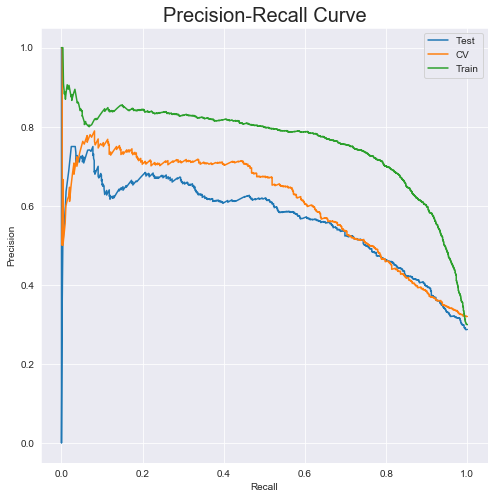

In [60]:
precision_test_tfidf_mnb_pr, recall_test_tfidf_mnb_pr, threshold_test_tfidf_mnb_pr = precision_recall_curve(y_test, preproba_test_tfidf_mnb)
precision_cv_tfidf_mnb_pr, recall_cv_tfidf_mnb_pr, threshold_cv_tfidf_mnb_pr = precision_recall_curve(y_cv, preproba_cv_tfidf_mnb)
precision_train_tfidf_mnb_pr, recall_train_tfidf_mnb_pr, threshold_train_tfidf_mnb_pr = precision_recall_curve(y_train, preproba_train_tfidf_mnb)
fig_1 = plt.figure()
ax_1 = plt.subplot(111)
ax_1.plot(recall_test_tfidf_mnb_pr, precision_test_tfidf_mnb_pr, label="Test")
ax_1.plot(recall_cv_tfidf_mnb_pr, precision_cv_tfidf_mnb_pr, label="CV")
ax_1.plot(recall_train_tfidf_mnb_pr, precision_train_tfidf_mnb_pr, label="Train")
plt.title('Precision-Recall Curve', fontsize=20)
plt.xlabel('Recall')
plt.ylabel('Precision')
ax_1.legend()
plt.show()

In the above line of code we plotted **Precision-Recall Curve** from **Test, Train and Cross-Validation Data**.

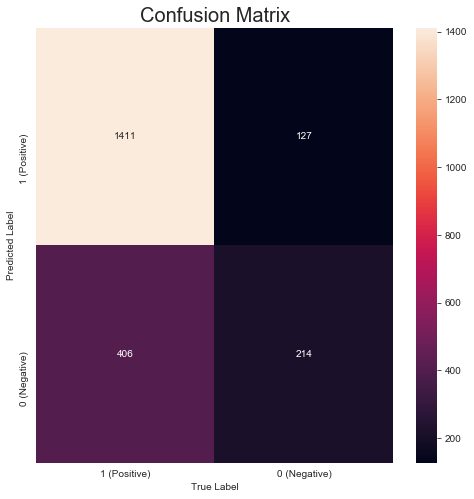

In [61]:
conf_test_tfidf_mnb = confusion_matrix(y_test, pre_test_tfidf_mnb)
class_label = ["1 (Positive)", "0 (Negative)"]
df = pd.DataFrame(conf_test_tfidf_mnb, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix", fontsize=20)
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()


# 5.2.3. - Decision-Tree Classifier :-

In [62]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [63]:
pre_cv_tfidf_dtc = dtc.predict(X_cv_tfidf)
pre_test_tfidf_dtc = dtc.predict(X_test_tfidf)

After **training the model** with the help of **TF-IDF & Decision-Tree Classifier** here in the above line of code I have stored **predictions** of **Cross-Validation & Test Data** for **further analysis**.

In [64]:
print("TF-IDF CV Classification Report by Decision-Tree Classifier")
print(classification_report(y_cv, pre_cv_tfidf_dtc))
print("="*100)
print("TF-_IDF Test Classification Report by Decision-Tree Classifier")
print(classification_report(y_test, pre_test_tfidf_dtc))

TF-IDF CV Classification Report by Decision-Tree Classifier
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1174
           1       0.55      0.45      0.49       553

    accuracy                           0.70      1727
   macro avg       0.65      0.64      0.64      1727
weighted avg       0.69      0.70      0.70      1727

TF-_IDF Test Classification Report by Decision-Tree Classifier
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1538
           1       0.47      0.46      0.46       620

    accuracy                           0.70      2158
   macro avg       0.63      0.62      0.62      2158
weighted avg       0.69      0.70      0.69      2158



We can see many things from above **Classification Report's** like **Precision**, **Recall**, **F1-score**, **Accuracy** of both the predictions which we got from **Cross-Validation & Test data**.

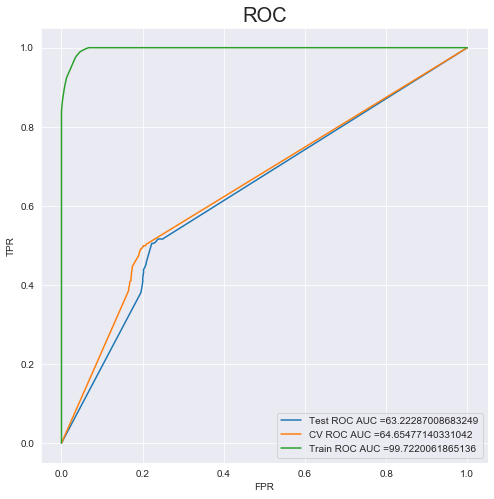

In [65]:
preproba_cv_tfidf_dtc = dtc.predict_proba(X_cv_tfidf)[:,1]
preproba_test_tfidf_dtc = dtc.predict_proba(X_test_tfidf)[:,1]
preproba_train_tfidf_dtc = dtc.predict_proba(X_train_tfidf)[:,1]

fpr_cv_tfidf_dtc_roc, tpr_cv_tfidf_dtc_roc, threshold_cv_tfidf_dtc_roc = roc_curve(y_cv, preproba_cv_tfidf_dtc)
fpr_test_tfidf_dtc_roc, tpr_test_tfidf_dtc_roc, threshold_test_tfidf_dtc_roc = roc_curve(y_test, preproba_test_tfidf_dtc)
fpr_train_tfidf_dtc_roc, tpr_train_tfidf_dtc_roc, threshold_train_tfidf_dtc_roc = roc_curve(y_train, preproba_train_tfidf_dtc)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr_test_tfidf_dtc_roc,tpr_test_tfidf_dtc_roc, label='Test ROC AUC ='+str(roc_auc_score(y_test,preproba_test_tfidf_dtc)*100))
ax.plot(fpr_cv_tfidf_dtc_roc, tpr_cv_tfidf_dtc_roc, label='CV ROC AUC ='+str(roc_auc_score(y_cv, preproba_cv_tfidf_dtc)*100))
ax.plot(fpr_train_tfidf_dtc_roc, tpr_train_tfidf_dtc_roc, label='Train ROC AUC ='+str(roc_auc_score(y_train, preproba_train_tfidf_dtc)*100))
plt.title('ROC', fontsize=20)
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

In the above line of code we plotted **Receiver Operating Characteristic (ROC) Curve** on all the **threshold's** possible and then drew this above diagram from **Test, Train and Cross-Validation Data**.

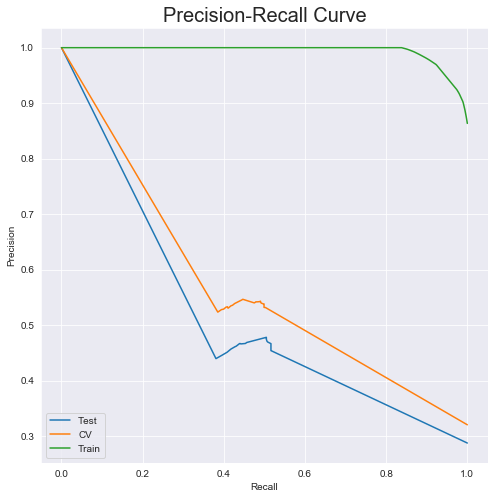

In [66]:
precision_test_tfidf_dtc_pr, recall_test_tfidf_dtc_pr, threshold_test_tfidf_dtc_pr = precision_recall_curve(y_test, preproba_test_tfidf_dtc)
precision_cv_tfidf_dtc_pr, recall_cv_tfidf_dtc_pr, threshold_cv_tfidf_dtc_pr = precision_recall_curve(y_cv, preproba_cv_tfidf_dtc)
precision_train_tfidf_dtc_pr, recall_train_tfidf_dtc_pr, threshold_train_tfidf_dtc_pr = precision_recall_curve(y_train, preproba_train_tfidf_dtc)
fig_1 = plt.figure()
ax_1 = plt.subplot(111)
ax_1.plot(recall_test_tfidf_dtc_pr, precision_test_tfidf_dtc_pr, label="Test")
ax_1.plot(recall_cv_tfidf_dtc_pr, precision_cv_tfidf_dtc_pr, label="CV")
ax_1.plot(recall_train_tfidf_dtc_pr, precision_train_tfidf_dtc_pr, label="Train")
plt.title('Precision-Recall Curve', fontsize=20)
plt.xlabel('Recall')
plt.ylabel('Precision')
ax_1.legend()
plt.show()

In the above line of code we plotted **Precision-Recall Curve** from **Test, Train and Cross-Validation Data**.

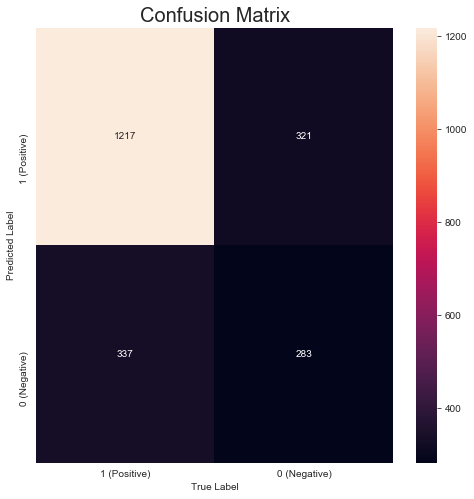

In [67]:
conf_test_tfidf_dtc = confusion_matrix(y_test, pre_test_tfidf_dtc)
class_label = ["1 (Positive)", "0 (Negative)"]
df = pd.DataFrame(conf_test_tfidf_dtc, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix", fontsize=20)
plt.ylabel("Predicted Label")
plt.xlabel("True Label")
plt.show()

# 5.2.4. - Comparison of TF-IDF Test's :-

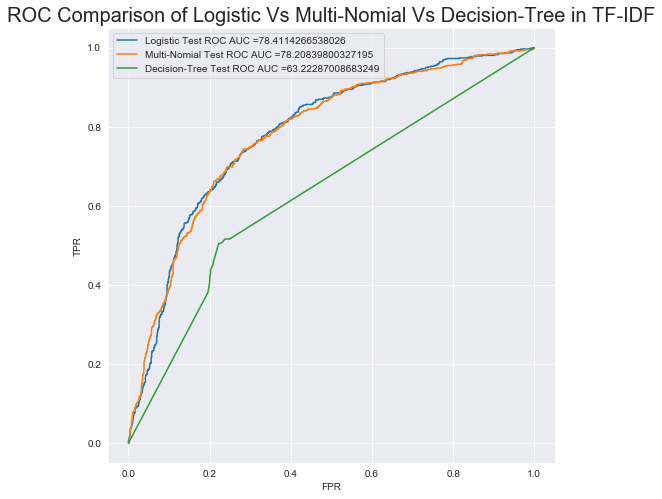

In [68]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr_test_tfidf_log_roc,tpr_test_tfidf_log_roc, label='Logistic Test ROC AUC ='+str(roc_auc_score(y_test,preproba_test_tfidf_log)*100))
ax.plot(fpr_test_tfidf_mnb_roc,tpr_test_tfidf_mnb_roc, label='Multi-Nomial Test ROC AUC ='+str(roc_auc_score(y_test,preproba_test_tfidf_mnb)*100))
ax.plot(fpr_test_tfidf_dtc_roc,tpr_test_tfidf_dtc_roc, label='Decision-Tree Test ROC AUC ='+str(roc_auc_score(y_test,preproba_test_tfidf_dtc)*100))
plt.title('ROC Comparison of Logistic Vs Multi-Nomial Vs Decision-Tree in TF-IDF', fontsize=20)
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

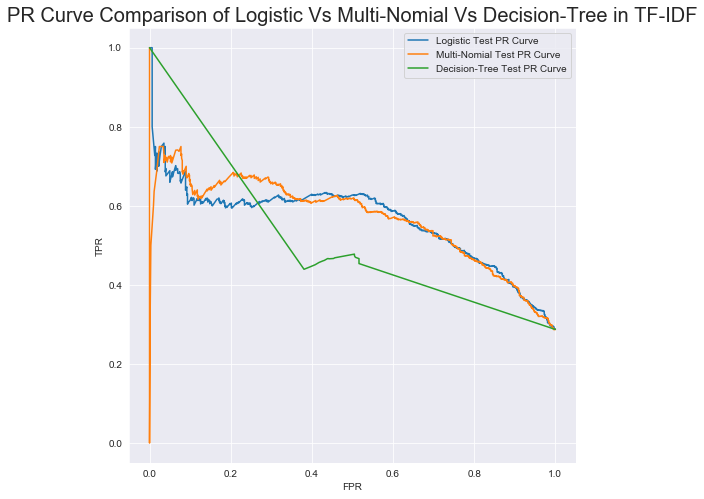

In [69]:
fig = plt.figure()
ax_1 = plt.subplot(111)
ax_1.plot(recall_test_tfidf_log_pr, precision_test_tfidf_log_pr, label="Logistic Test PR Curve")
ax_1.plot(recall_test_tfidf_mnb_pr, precision_test_tfidf_mnb_pr, label="Multi-Nomial Test PR Curve")
ax_1.plot(recall_test_tfidf_dtc_pr, precision_test_tfidf_dtc_pr, label="Decision-Tree Test PR Curve")
plt.title('PR Curve Comparison of Logistic Vs Multi-Nomial Vs Decision-Tree in TF-IDF', fontsize=20)
plt.xlabel('FPR')
plt.ylabel('TPR')
ax_1.legend()
plt.show()

# 5.3. - Final Comparison :-

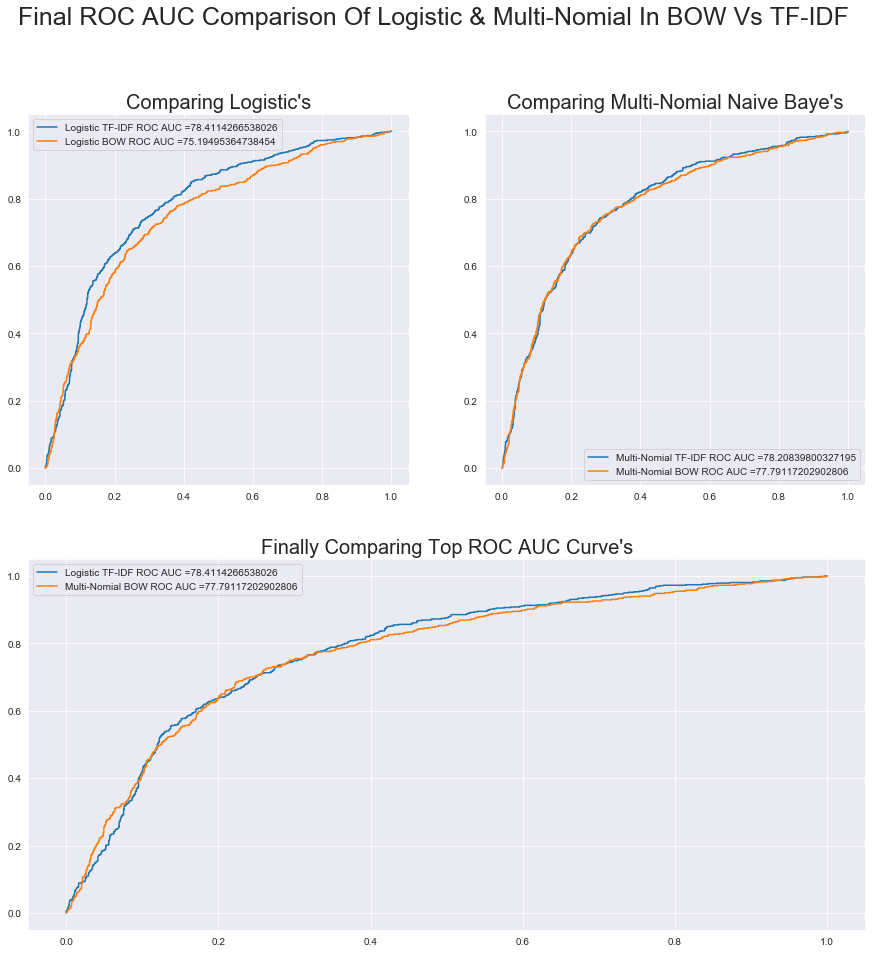

In [70]:
fig_2 = plt.figure(figsize=(15,15))

# Ploting fig_2
ax_5 = plt.subplot(221)
ax_5.set_title("Comparing Logistic's", fontsize=20)
ax_5.plot(fpr_test_tfidf_log_roc,tpr_test_tfidf_log_roc, label='Logistic TF-IDF ROC AUC ='+str(roc_auc_score(y_test,preproba_test_tfidf_log)*100))
ax_5.plot(fpr_test_bow_log_roc,tpr_test_bow_log_roc, label='Logistic BOW ROC AUC ='+str(roc_auc_score(y_test,preproba_test_bow_log)*100))

ax_6 = plt.subplot(222)
ax_6.set_title("Comparing Multi-Nomial Naive Baye's", fontsize=20)
ax_6.plot(fpr_test_tfidf_mnb_roc,tpr_test_tfidf_mnb_roc, label='Multi-Nomial TF-IDF ROC AUC ='+str(roc_auc_score(y_test,preproba_test_tfidf_mnb)*100))
ax_6.plot(fpr_test_bow_mnb_roc,tpr_test_bow_mnb_roc, label='Multi-Nomial BOW ROC AUC ='+str(roc_auc_score(y_test,preproba_test_bow_mnb)*100))

ax_7 = plt.subplot(212)
ax_7.set_title("Finally Comparing Top ROC AUC Curve's", fontsize=20)
ax_7.plot(fpr_test_tfidf_log_roc,tpr_test_tfidf_log_roc, label='Logistic TF-IDF ROC AUC ='+str(roc_auc_score(y_test,preproba_test_tfidf_log)*100))
ax_7.plot(fpr_test_bow_mnb_roc,tpr_test_bow_mnb_roc, label='Multi-Nomial BOW ROC AUC ='+str(roc_auc_score(y_test,preproba_test_bow_mnb)*100))


ax_5.legend()
ax_6.legend()
ax_7.legend()
plt.suptitle('Final ROC AUC Comparison Of Logistic & Multi-Nomial In BOW Vs TF-IDF', fontsize=25)
plt.show()


# 5.4. - Conclusion :-

In [71]:
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "AUC (in %)", "Precision Score (in %)", "Recall Score (in %)"]
x.add_row(["BOW", "Logistic Regression", round(roc_auc_score(y_test,preproba_test_bow_log)*100), round(precision_score(y_test,pre_test_bow_log)*100), round(recall_score(y_test,pre_test_bow_log)*100)])
x.add_row(["BOW", "Multi-Nomial Naive Bayes", round(roc_auc_score(y_test,preproba_test_bow_mnb)*100), round(precision_score(y_test,pre_test_bow_mnb)*100), round(recall_score(y_test,pre_test_bow_mnb)*100)])
x.add_row(["BOW", "Decision-Tree Classifier", round(roc_auc_score(y_test,preproba_test_bow_dtc)*100), round(precision_score(y_test,pre_test_bow_dtc)*100), round(recall_score(y_test,pre_test_bow_dtc)*100)])
x.add_row(["TF-IDF", "Logistic Regression", round(roc_auc_score(y_test,preproba_test_tfidf_log)*100), round(precision_score(y_test,pre_test_tfidf_log)*100), round(recall_score(y_test,pre_test_tfidf_log)*100)])
x.add_row(["TF-IDF", "Multi-Nomial Naive Bayes", round(roc_auc_score(y_test,preproba_test_tfidf_mnb)*100), round(precision_score(y_test,pre_test_tfidf_mnb)*100), round(recall_score(y_test,pre_test_tfidf_mnb)*100)])
x.add_row(["TF-IDF", "Decision-Tree Classifier", round(roc_auc_score(y_test,preproba_test_tfidf_dtc)*100), round(precision_score(y_test,pre_test_tfidf_dtc)*100), round(recall_score(y_test,pre_test_tfidf_dtc)*100)])
print(x)


+------------+--------------------------+------------+------------------------+---------------------+
| Vectorizer |          Model           | AUC (in %) | Precision Score (in %) | Recall Score (in %) |
+------------+--------------------------+------------+------------------------+---------------------+
|    BOW     |   Logistic Regression    |    75.0    |          57.0          |         44.0        |
|    BOW     | Multi-Nomial Naive Bayes |    78.0    |          60.0          |         54.0        |
|    BOW     | Decision-Tree Classifier |    64.0    |          49.0          |         44.0        |
|   TF-IDF   |   Logistic Regression    |    78.0    |          61.0          |         33.0        |
|   TF-IDF   | Multi-Nomial Naive Bayes |    78.0    |          63.0          |         35.0        |
|   TF-IDF   | Decision-Tree Classifier |    63.0    |          47.0          |         46.0        |
+------------+--------------------------+------------+------------------------+---

***So, by all these Comparison's and by this Conclusion Table we can select the Best Algorithm with Best Featurization Technique which suit's our priorities / requirements {Like :- Some gives more priority to ROC-AUC or some give priority to Precision-Recall}.***

![title](thank_you2.png "Header")